# Introduction to the Notebook
This Jupyter notebook is dedicated to the analysis of friendship networks among high school and university students over time, utilizing a unique dataset derived from a popular social networking site. The dataset captures the evolution of these networks by recording "likes" exchanged among students, with each time point in the dataset representing a three-month period. By combining this social network data with academic performance metrics, specifically GPA, we aim to explore the concept of Homophily within these networks. Homophily, in this context, refers to the tendency of individuals to associate and bond with similar others, particularly in terms of academic performance.

## Sections Overview
1. **Data Import and Preprocessing**: In this section, we load the dataset, which includes two main components: the high school dataset and the seniors' dataset from a university. We preprocess the data to ensure it is clean and suitable for analysis.

2. **Network Construction**: Utilizing the "likes" data, we construct friendship networks for both high school and university students. Each node in the network represents a student, while edges represent the "likes" exchanged between students.

3. **Academic Performance Analysis**: Here, we analyze the GPA data provided for individual students. This analysis includes descriptive statistics and the distribution of GPA scores among the students.

4. **Homophily Index Calculation**: We compute the Homophily Index, H, using Pearson's correlation coefficient. This index measures the correlation between a student's GPA and the average GPA of their friends, allowing us to track the evolution of homophily over time.

5. **Time Evolution of Networks**: In this section, we examine how the friendship networks and the Homophily Index change over the specified three-month periods. This analysis helps us understand the dynamics of social interactions and academic performance.

6. **Conclusion and Insights**: We conclude by summarizing our findings, discussing the implications of homophily in academic settings, and suggesting areas for future research.

## Background on the Project
The dataset used in this project provides a fascinating glimpse into the dynamics of friendship networks among students and their correlation with academic performance. The methodology and detailed description of data collection and analysis are documented in the research paper available at https://arxiv.org/abs/1606.09082. This project aims to contribute to the understanding of social dynamics in educational settings and the factors influencing academic success.


## Import Required Libraries

In [2]:
import pandas as pd
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap

## Define Helper Functions 

In [3]:
def read_excel_sheets_to_np_arrays(file_path):
    """
    Reads all sheets from an Excel file and converts them to numpy arrays.

    Parameters:
    - file_path (str): The path to the Excel file.

    Returns:
    - dict: A dictionary where keys are sheet names and values are the corresponding numpy arrays.
    """
    # Load the Excel file
    xls = pd.ExcelFile(file_path)
    
    # Initialize an empty dictionary to store numpy arrays
    sheets_np = {}
    
    # Iterate over all sheet names
    for sheet_name in xls.sheet_names:
        # Read the current sheet to a pandas DataFrame
        df = pd.read_excel(xls, sheet_name=sheet_name, header=None)
        # Convert the DataFrame to a numpy array and store it in the dictionary
        sheets_np[sheet_name] = df.to_numpy()
    
    return sheets_np


In [5]:
def plot_network_from_matrix(adj_matrix, plot_only_connected_nodes=False, title='Network Graph', node_weights=None):
    """
    Plots a network graph from a given adjacency matrix where each row and column
    represents a node, and a '1' in the matrix indicates an interaction (edge)
    between the corresponding nodes.

    Parameters:
    - adj_matrix (np.array): A binary (0 or 1) 2D numpy array representing the adjacency matrix of the graph.
    - plot_only_connected_nodes (bool): If True, only nodes with at least one edge are plotted.
    """
    # Create a graph
    G = nx.from_numpy_array(adj_matrix)

    # Optional: Remove isolated nodes if the flag is True
    if plot_only_connected_nodes:
        G.remove_nodes_from(list(nx.isolates(G)))

    # Prepare the node colors based on weights using a colormap
    if node_weights is not None:
        if len(node_weights) != len(G.nodes):
            raise ValueError("The number of node weights must match the number of nodes in the graph.")
        node_color = node_weights
        cmap = plt.cm.magma  
        vmin = min(node_weights)
        vmax = max(node_weights)
    else:
        node_color = '#1f78b4'  # Default color if no weights are given
        cmap = None
        vmin = None
        vmax = None

    # Draw the graph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.27)  # positions for all nodes
    nx.draw_networkx_nodes(G, pos, node_size=20, cmap=cmap, node_color=node_color, vmin=vmin, vmax=vmax)
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)

    # If a colormap is used, add a colorbar
    if cmap:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        plt.colorbar(sm, label='Node Weights')
    
    plt.title(title)
    plt.axis('off')  # Turn off the axis
    plt.show()

In [6]:
def adjacency_matrix_to_list_and_save(matrix, filename="adjacency_list.csv", students_file="students_list.csv"):
    """
    Converts an adjacency matrix to an adjacency list format and saves it to a CSV file.
    Also creates a separate CSV file listing all students (nodes) by index.

    Parameters:
    - matrix (np.array): A numpy array representing the adjacency matrix.
    - filename (str): The name of the file to save the adjacency list to.
    - students_file (str): The name of the file to list all students' indices.
    """
    # Number of nodes
    num_nodes = matrix.shape[0]

    # Create adjacency list
    adjacency_list = []
    for i in range(num_nodes):
        # Find indices of adjacent nodes
        adjacent_nodes = np.where(matrix[i] == 1)[0]
        for j in adjacent_nodes:
            adjacency_list.append([i, j])

    # Write to CSV file for adjacency list
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Source', 'Target'])  # Header
        writer.writerows(adjacency_list)

    print(f"Adjacency list saved to {filename}")

    # Create list of student indices
    students_indices = [[i] for i in range(num_nodes)]

    # Write to CSV file for student indices
    with open(students_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Students'])  # Header
        writer.writerows(students_indices)

    print(f"Students list saved to {students_file}")

In [7]:
def network_analysis_with_gpa(adj_matrix, gpas):
    """
    Performs a comprehensive network analysis on the given adjacency matrix, integrating student GPA data.

    Parameters:
    - adj_matrix (np.array): A numpy 2D array representing the binary adjacency matrix of the graph.
    - gpas (list or np.array): A list or array of GPA scores for each student (node) in the network.

    Returns:
    - report_df: A pandas dataframe containing various network metrics and their values, including GPA-related analyses.
    """
    # Create the graph from the adjacency matrix
    G = nx.from_numpy_array(adj_matrix)

    # Compute various centrality measures
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
    clustering_coefficient = nx.clustering(G)

    # Compute GPA-weighted Degree Centrality
    gpa_weighted_degree = {node: degree_centrality[node] * gpas[node] for node in G.nodes}

    # Correlations between GPA and centrality measures
    df = pd.DataFrame({
        'GPA': gpas,
        'Degree Centrality': list(degree_centrality.values()),
        'Closeness Centrality': list(closeness_centrality.values()),
        'Betweenness Centrality': list(betweenness_centrality.values()),
        'Eigenvector Centrality': list(eigenvector_centrality.values())
    })
    correlations = df.corr().loc['GPA']

    # Plot GPA distribution across connected components and distribution of components across GPA
    component_gp_avg = {}
    component_names = []
    avg_gpas = []
    component_sizes = []  # To store the size of each component
    for component in nx.connected_components(G):
        component_gpas = [gpas[node] for node in component]
        avg_gpa = np.mean(component_gpas)
        component_name = f"Component_{min(component)}"
        component_gp_avg[component_name] = avg_gpa
        component_names.append(component_name)
        avg_gpas.append(avg_gpa)
        component_sizes.append(len(component))  # Store the size of the component

    # Plot for Average GPA Distribution Across Connected Components
    plt.figure(figsize=(10, 6))
    plt.bar(component_names, avg_gpas, color='skyblue')
    plt.xlabel('Components')
    plt.ylabel('Average GPA')
    plt.title('Average GPA Distribution Across Connected Components')
    plt.xticks(ticks=[], labels=[])  # No x labels for each component, only x label name
    plt.tight_layout()
    plt.show()

    # Plot for Distribution of Components Across GPA
    plt.figure(figsize=(10, 6))
    plt.scatter(avg_gpas, component_sizes, color='lightgreen')
    plt.xlabel('Average GPA')
    plt.ylabel('Component Size')
    plt.title('Distribution of Components Across GPA')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot GPA vs. clustering coefficient
    plt.figure()
    plt.scatter(list(clustering_coefficient.values()), gpas, alpha=0.7)
    plt.title('GPA vs. Clustering Coefficient')
    plt.xlabel('Clustering Coefficient')
    plt.ylabel('GPA')
    plt.grid(True)
    plt.show()

    # Plot GPA vs. centrality measures
    centrality_measures = ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality', 'Eigenvector Centrality']
    for centrality in centrality_measures:
        plt.figure()
        plt.scatter(df[centrality], df['GPA'], alpha=0.7)
        plt.title(f'GPA vs. {centrality}')
        plt.xlabel(centrality)
        plt.ylabel('GPA')
        plt.grid(True)
        plt.show()
        
    # Assemble the report as a pandas DataFrame
    report_df = pd.DataFrame({
        'GPA': gpas,
        'Degree Centrality': list(degree_centrality.values()),
        'Closeness Centrality': list(closeness_centrality.values()),
        'Betweenness Centrality': list(betweenness_centrality.values()),
        'Eigenvector Centrality': list(eigenvector_centrality.values()),
        'Clustering Coefficient': list(clustering_coefficient.values()),
        'GPA-Weighted Degree Centrality': list(gpa_weighted_degree.values()),
        # 'Correlations between GPA and Centralities': correlations.tolist(),
        # 'GPA by Component': list(component_gp_avg.values())
    }, index=list(degree_centrality.keys()))

    return report_df

## Analysis of the Networks Schools Dataset

This section delves into an in-depth analysis of a dataset encompassing 655 high school students. It tracks their social interactions across six distinct time periods, alongside their academic performance, as measured by GPA scores recorded during these intervals.

### Load the data

In [6]:
# Extract the numpy arrays from the Excel file
networks_school_np = read_excel_sheets_to_np_arrays('./data/networks_school.xlsx')
# Accessing the numpy arrays can be done by sheets_np['Sheet1'], sheets_np['Sheet2'], etc.

### Plotting the network graphs of the school at each time

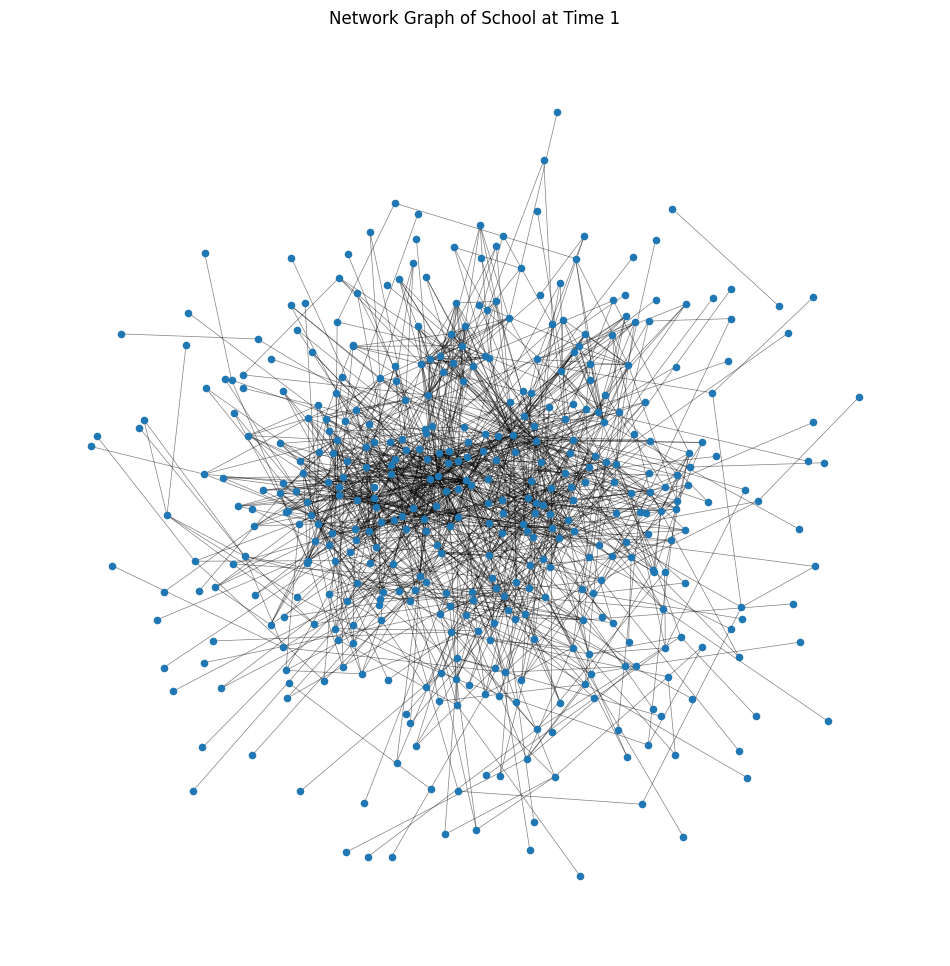

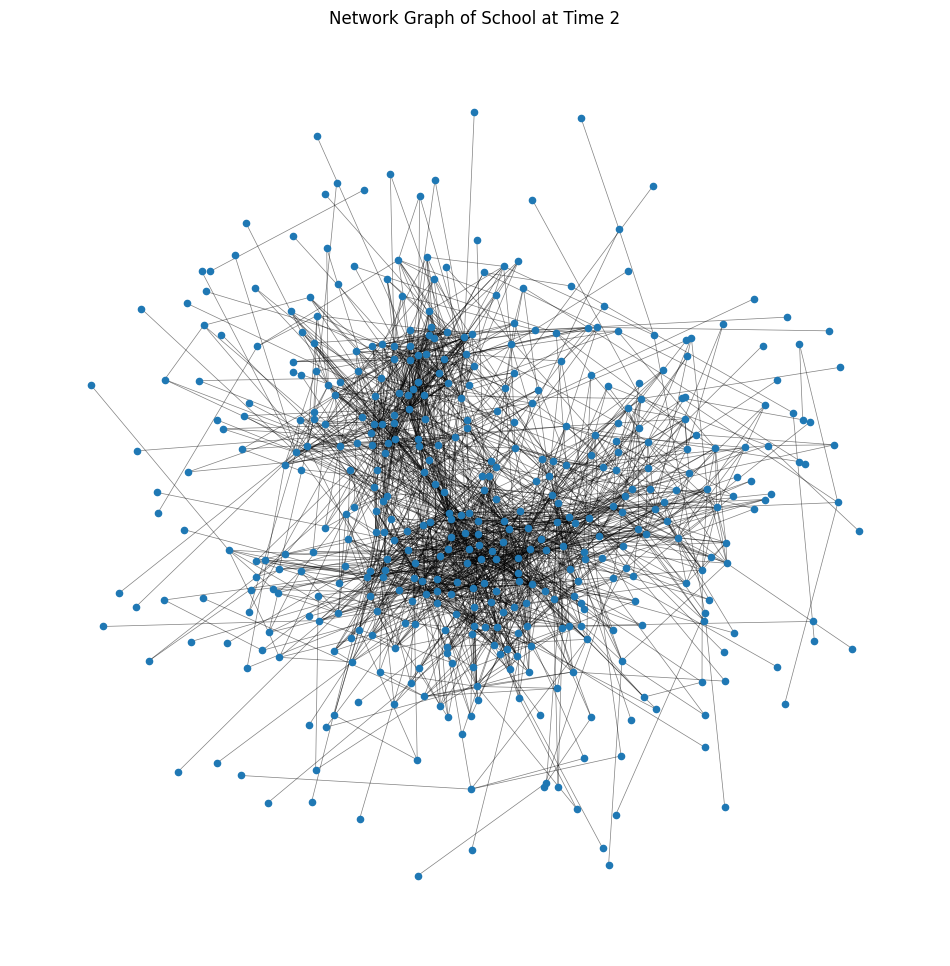

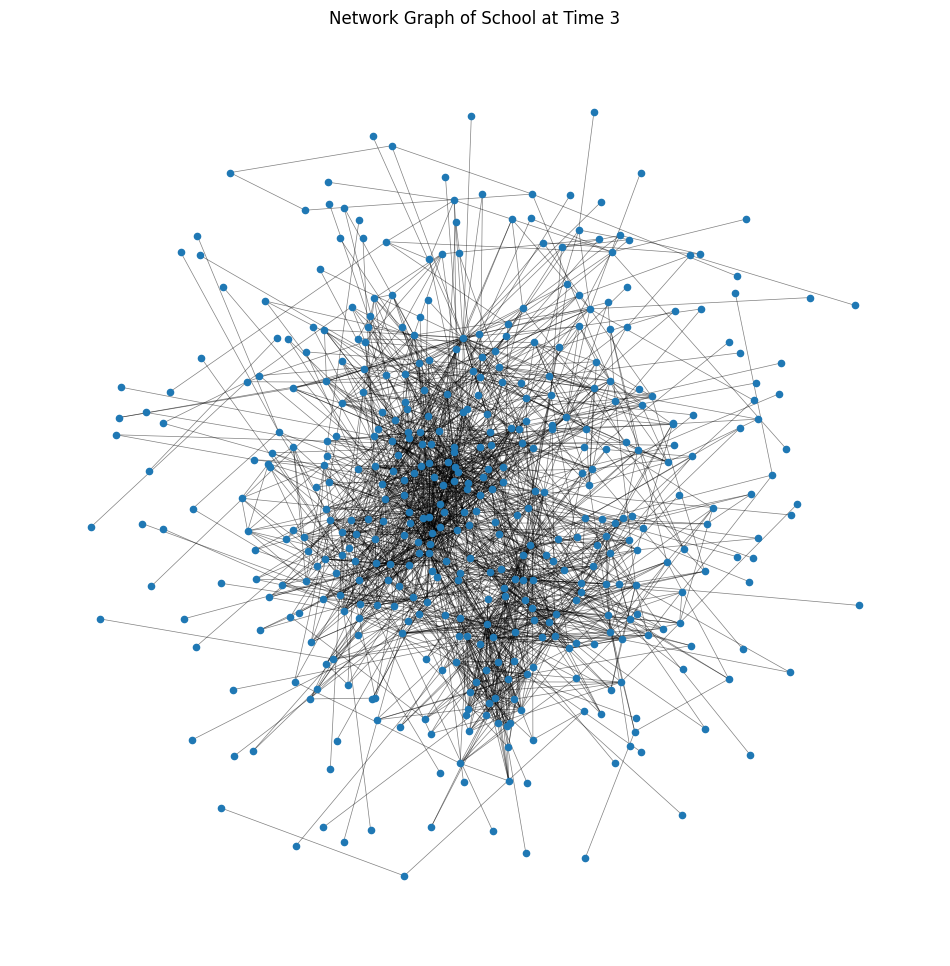

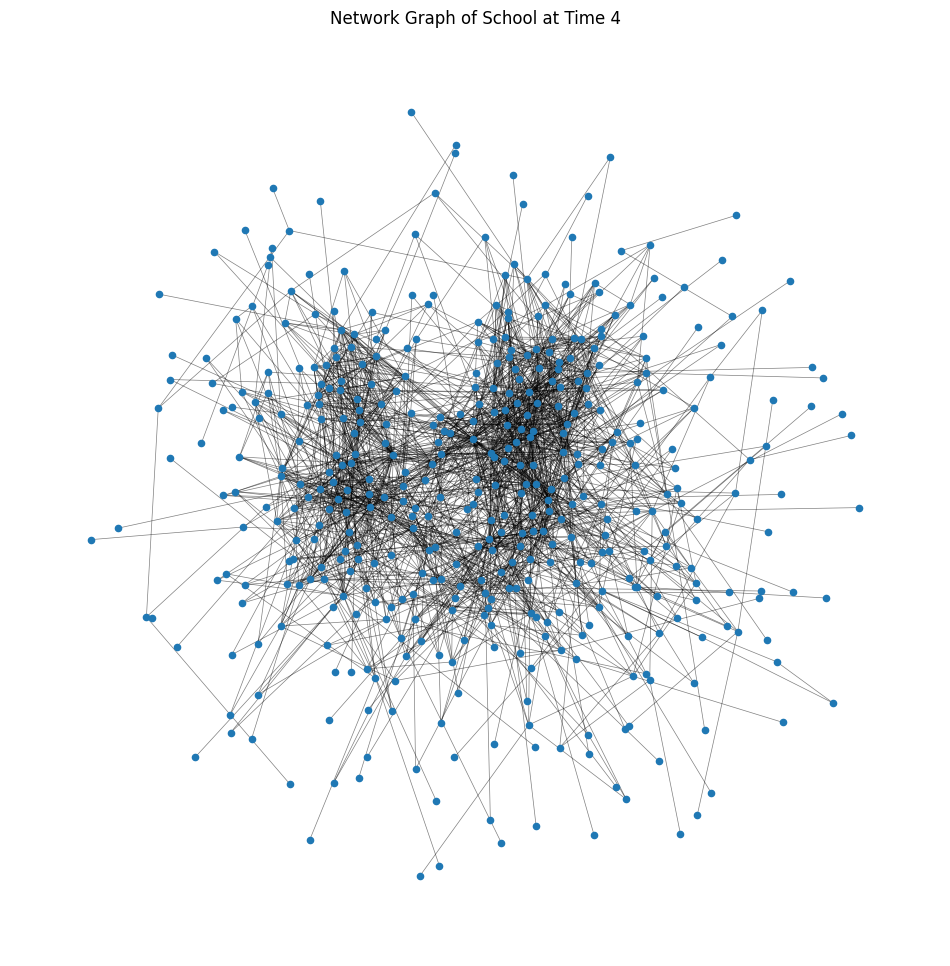

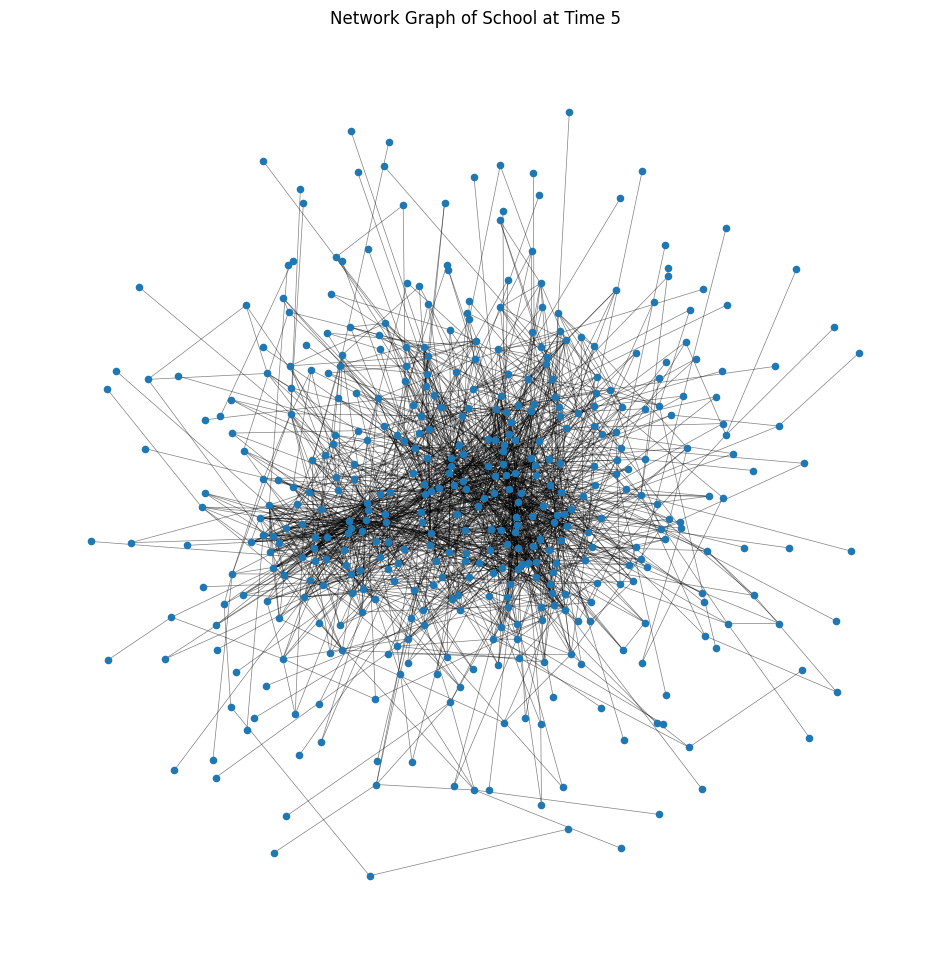

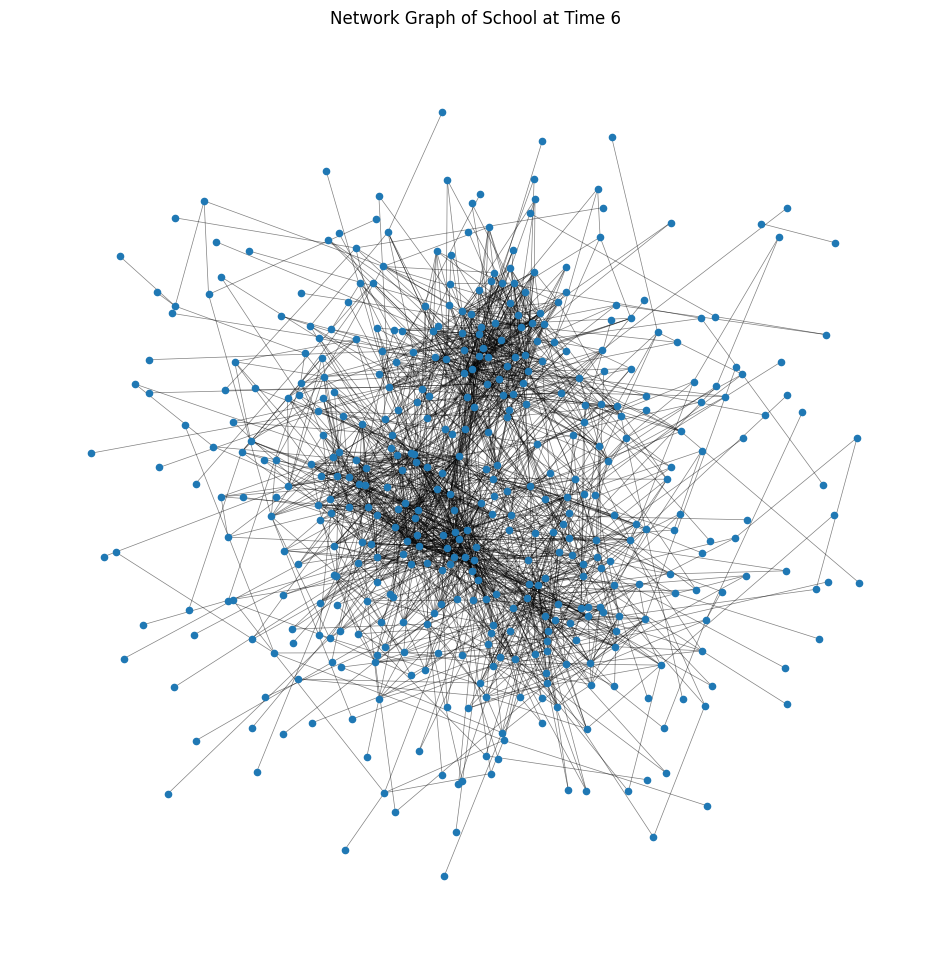

In [7]:
plot_network_from_matrix(networks_school_np['Sheet1'], plot_only_connected_nodes=True, title='Network Graph of School at Time 1')
plot_network_from_matrix(networks_school_np['Sheet2'], plot_only_connected_nodes=True, title='Network Graph of School at Time 2')
plot_network_from_matrix(networks_school_np['Sheet2'], plot_only_connected_nodes=True, title='Network Graph of School at Time 3')
plot_network_from_matrix(networks_school_np['Sheet2'], plot_only_connected_nodes=True, title='Network Graph of School at Time 4')
plot_network_from_matrix(networks_school_np['Sheet2'], plot_only_connected_nodes=True, title='Network Graph of School at Time 5')
plot_network_from_matrix(networks_school_np['Sheet2'], plot_only_connected_nodes=True, title='Network Graph of School at Time 6')

### Extract the adjeacency list for visualizations on Flourish

The interactive graph can be viewed here: https://public.flourish.studio/visualisation/17647342/

In [8]:
adjacency_matrix_to_list_and_save(networks_school_np['Sheet1'], filename="./data/adjacency_list.csv", students_file="./data/students_list.csv")

Adjacency list saved to ./data/adjacency_list.csv
Students list saved to ./data/students_list.csv


### Load the GPA data and visualize the network

C:\Users\ethan\AppData\Local\Temp\ipykernel_7492\2786856023.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Node Weights')


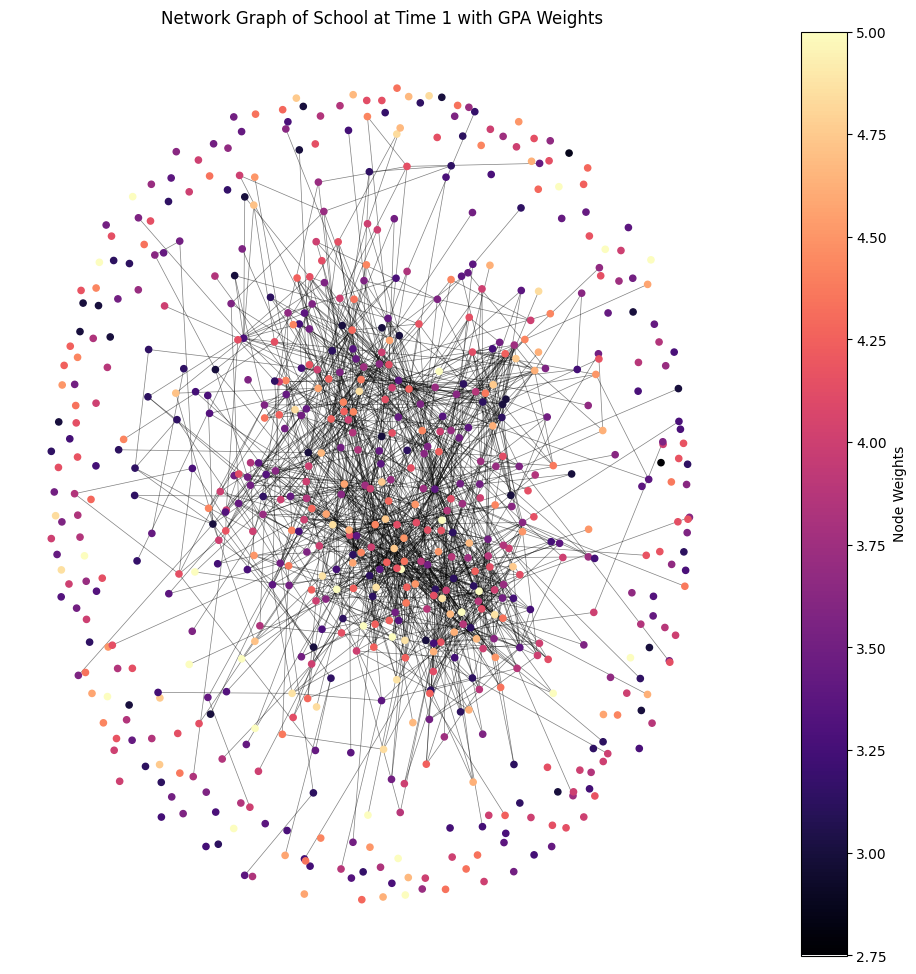

In [9]:
# Load the gpa data
gpa_data = pd.read_excel('./data/gpa_school.xlsx', header=None)

# Get first column of gpa data (Time 1)
gpa_data_1 = gpa_data[0].to_numpy()

# Plot network graph with gpa weights
plot_network_from_matrix(networks_school_np['Sheet1'], plot_only_connected_nodes=False, title='Network Graph of School at Time 1 with GPA Weights', node_weights=gpa_data_1)

### Find the top 10 nodes by in and out-degree centrality

In [19]:
# Perform network analysis of in and out-degree centrality
G = nx.from_numpy_array(networks_school_np['Sheet1'], create_using=nx.DiGraph)

# Comute the in-degree and out-degree centrality of each node
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

# Sort the nodes by in-degree centrality
sorted_in_degree_centrality = {k: v for k, v in sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True)}

# Sort the nodes by out-degree centrality
sorted_out_degree_centrality = {k: v for k, v in sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse=True)}

# Print the top 10 nodes by in-degree centrality
print("Top 10 nodes by in-degree centrality:")
for i, (node, centrality) in enumerate(sorted_in_degree_centrality.items()):
    print(f"{i+1}. Node {node}: {centrality:.3f}")
    if i == 9:
        break

# Print the top 10 nodes by out-degree centrality
print("\nTop 10 nodes by out-degree centrality:")
for i, (node, centrality) in enumerate(sorted_out_degree_centrality.items()):
    print(f"{i+1}. Node {node}: {centrality:.3f}")
    if i == 9:
        break

Top 10 nodes by in-degree centrality:
1. Node 17: 0.076
2. Node 126: 0.055
3. Node 582: 0.050
4. Node 61: 0.043
5. Node 56: 0.041
6. Node 2: 0.037
7. Node 146: 0.037
8. Node 18: 0.035
9. Node 33: 0.035
10. Node 111: 0.035

Top 10 nodes by out-degree centrality:
1. Node 40: 0.058
2. Node 3: 0.052
3. Node 126: 0.049
4. Node 649: 0.046
5. Node 96: 0.043
6. Node 19: 0.037
7. Node 60: 0.028
8. Node 239: 0.028
9. Node 47: 0.026
10. Node 115: 0.026


### EDA report on the network

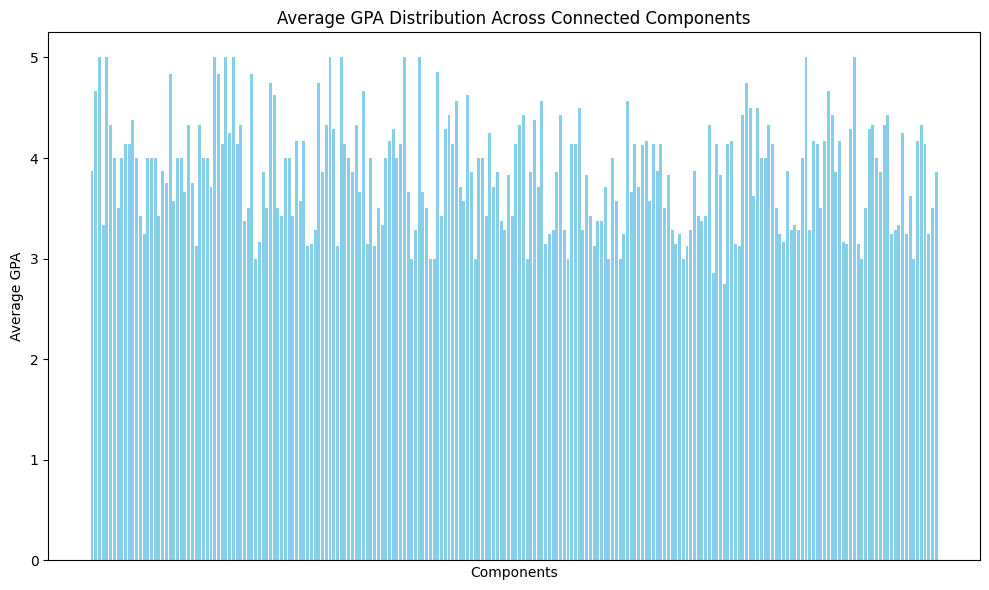

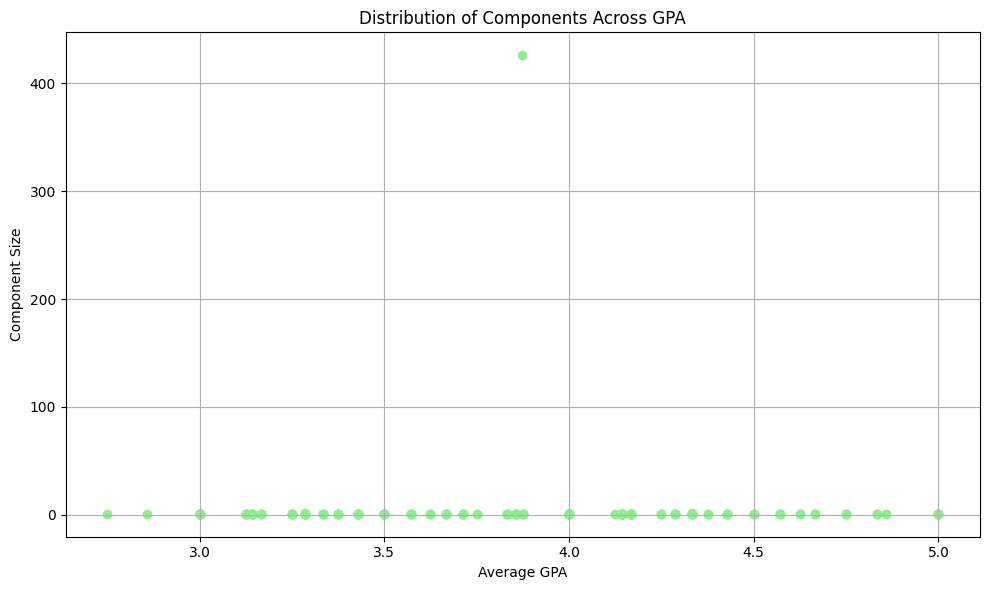

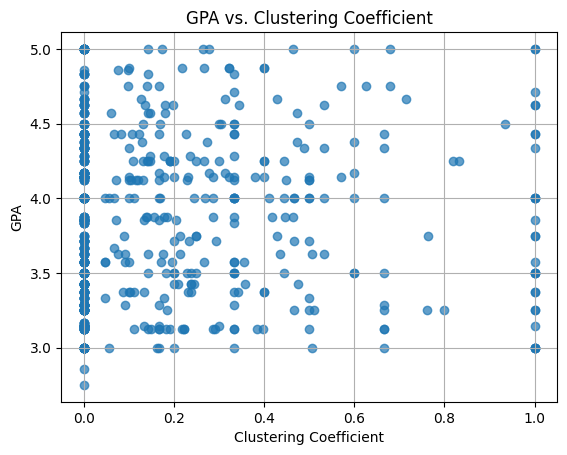

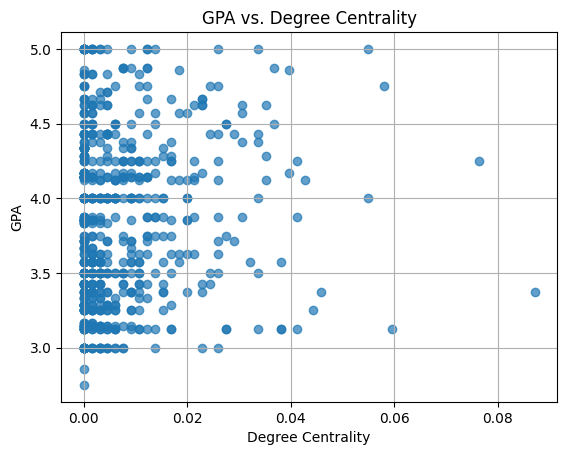

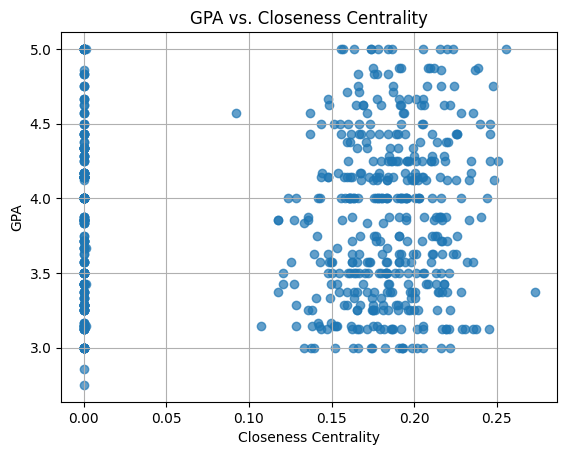

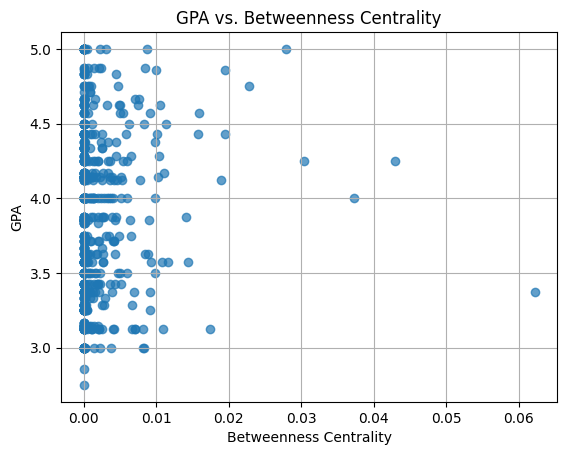

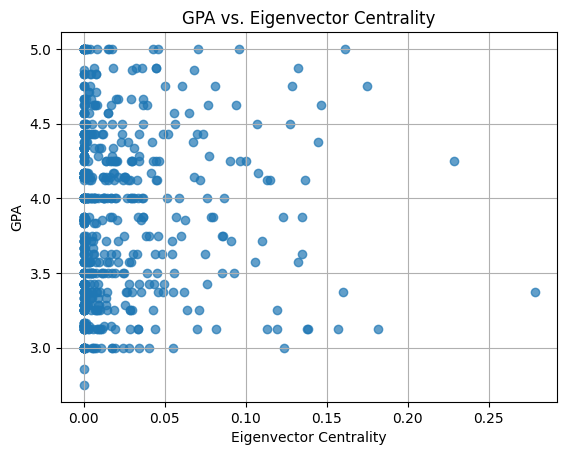

In [11]:
networks_school_report = network_analysis_with_gpa(networks_school_np['Sheet1'], gpa_data_1)

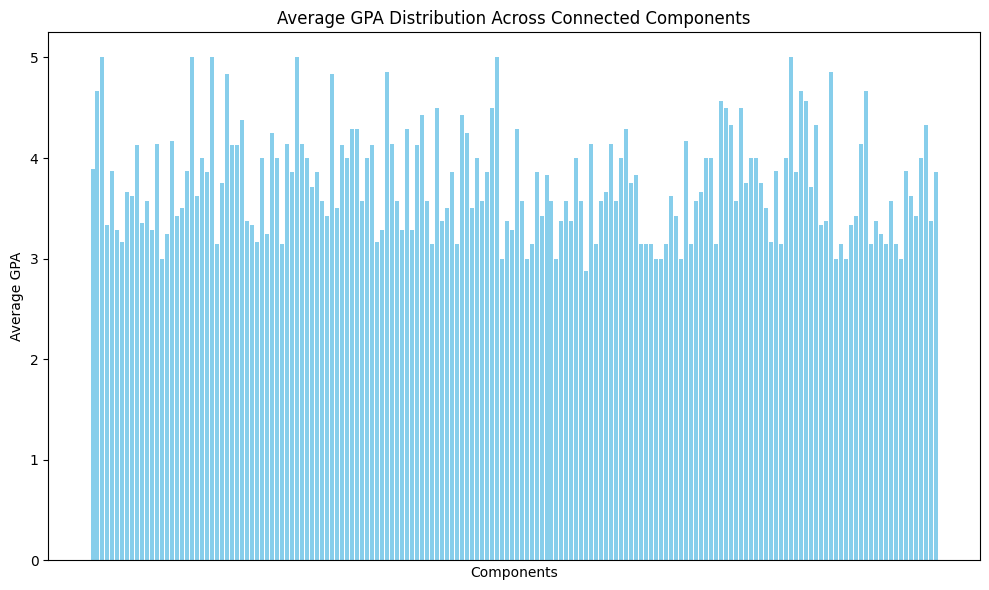

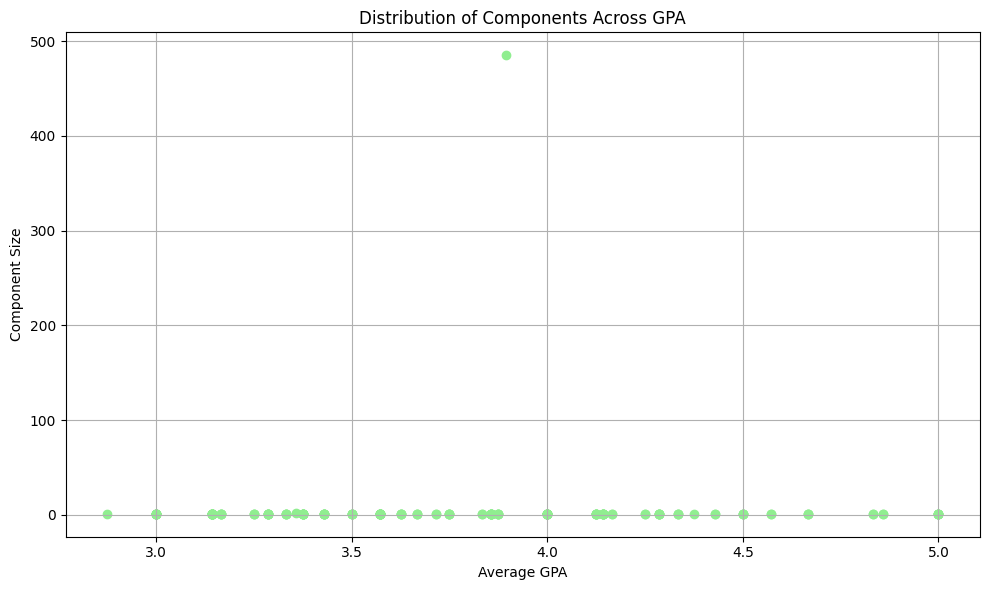

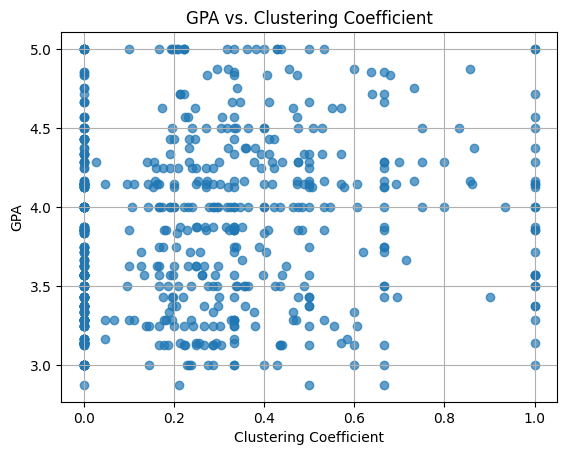

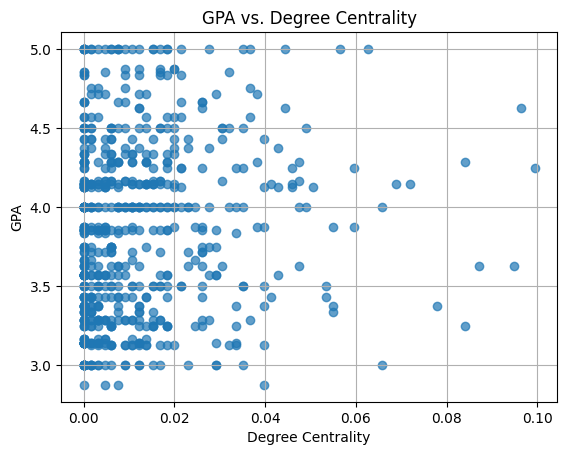

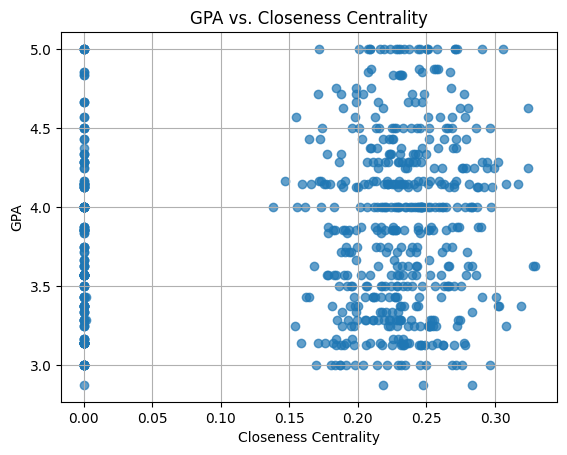

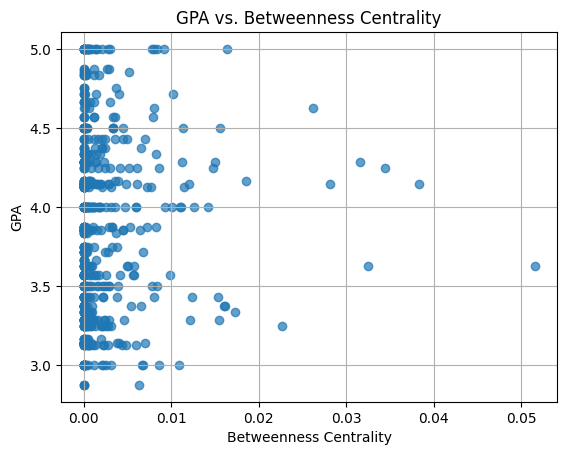

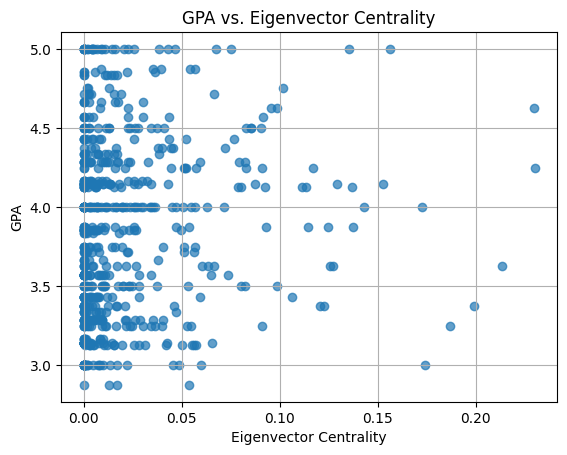

In [12]:
# Get gpa data from Time 6
gpa_data_6 = gpa_data[5].to_numpy()

networks_school_report = network_analysis_with_gpa(networks_school_np['Sheet6'], gpa_data_6)

### Reciprocity score

In [13]:
G = nx.from_numpy_array(networks_school_np['Sheet1'], create_using=nx.DiGraph)
reciprocity = nx.reciprocity(G)
print(f"Reciprocity: {reciprocity}")

Reciprocity: 0.21399652978600348


### Random Forest Regression to predict GPA based on centrality

Mean Squared Error: 0.3262658181981827
Feature Importances:
Closeness Centrality: 0.2738729591053157
Eigenvector Centrality: 0.23548426525311159
Clustering Coefficient: 0.2080516617160318
Betweenness Centrality: 0.17461184772582164
Degree Centrality: 0.10797926619971915


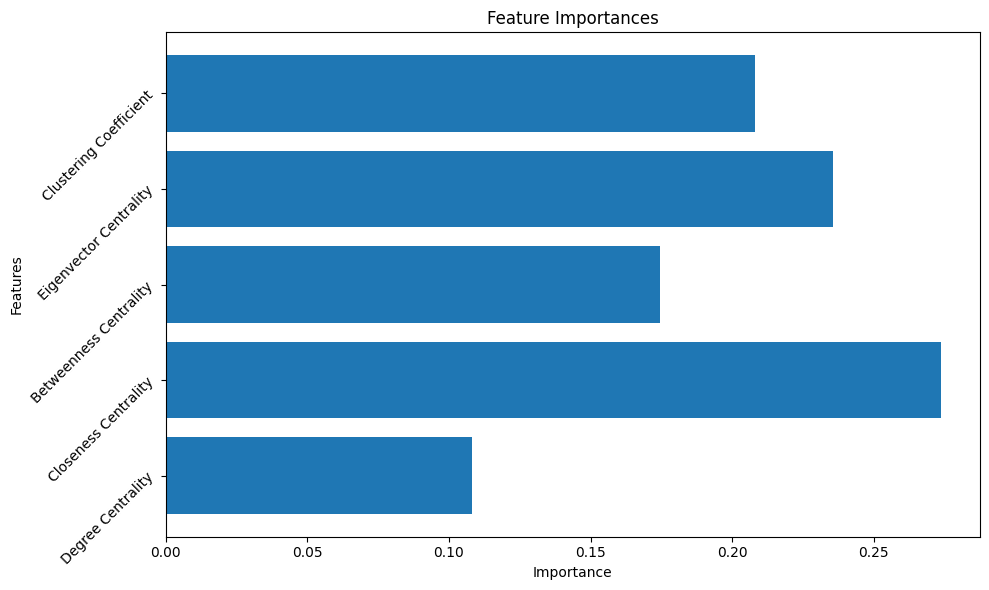

In [14]:
# Prepare the data
X = networks_school_report.drop(columns=['GPA', 'GPA-Weighted Degree Centrality'], axis=1)
y = networks_school_report['GPA']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Feature importance
feature_importances = rf.feature_importances_
importance_dict = dict(zip(X.columns, feature_importances))
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")

# Plot the feature importances in a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, tick_label=X.columns)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

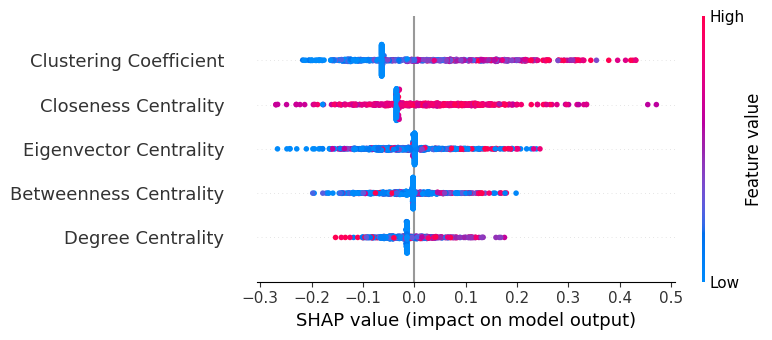

In [15]:
# Plot SHAP values

# Create an explainer object
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values
shap_values = explainer.shap_values(X)

# Summary plot with color
shap.summary_plot(shap_values, X, plot_type="dot")

# Force plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X, link="logit", matplotlib=False)

### Study of homophily

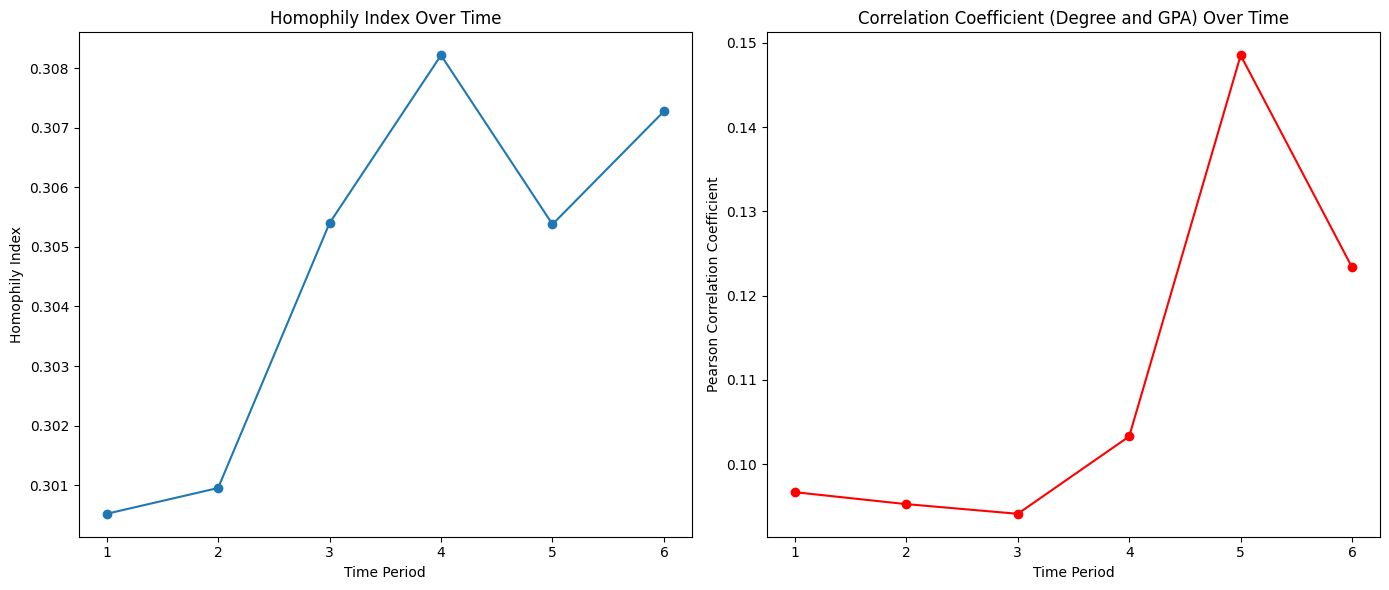

In [16]:
# Function to calculate homophily index
def calculate_homophily(graph, node_attributes):
    same_attr_edges = 0
    total_edges = 0
    for edge in graph.edges():
        if node_attributes[edge[0]] == node_attributes[edge[1]]:
            same_attr_edges += 1
        total_edges += 1
    if total_edges > 0:
        return same_attr_edges / total_edges
    else:
        return 0

# Initialize lists to store results
homophily_indices = []
correlation_coefficients = []

# Load GPA data
gpa_data_all = pd.read_excel('./data/gpa_school.xlsx', header=None)

# Loop through each sheet/time period
for i in range(1, 7):
    sheet_name = f'Sheet{i}'
    adjacency_matrix = networks_school_np[sheet_name]

    # Get GPA data for the current time period
    gpa_data = gpa_data_all[i - 1].values.flatten()  # Ensure gpa_data is correctly indexed

    if i == 1:
        # Normalize GPA data for homophily calculation (discretize)
        gpa_categories = pd.qcut(gpa_data, q=4, labels=False)
        
    # Create graph from adjacency matrix
    G = nx.from_numpy_array(adjacency_matrix)
    
    # Calculate homophily index
    homophily_index = calculate_homophily(G, gpa_categories)
    homophily_indices.append(homophily_index)
    
    # Calculate Pearson correlation coefficient between node degrees and GPA
    degrees = list(nx.degree_centrality(G).values())  # Convert degrees to list for pearsonr compatibility
    correlation_coefficient, _ = pearsonr(degrees, gpa_data)
    correlation_coefficients.append(correlation_coefficient)

# Plotting the results
time_periods = range(1, 7)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(time_periods, homophily_indices, marker='o', linestyle='-')
plt.title('Homophily Index Over Time')
plt.xlabel('Time Period')
plt.ylabel('Homophily Index')

plt.subplot(1, 2, 2)
plt.plot(time_periods, correlation_coefficients, marker='o', linestyle='-', color='r')
plt.title('Correlation Coefficient (Degree and GPA) Over Time')
plt.xlabel('Time Period')
plt.ylabel('Pearson Correlation Coefficient')

plt.tight_layout()
plt.show()

In [20]:
# # Import counter class from collections module
# from collections import Counter

# # Compute homophily gain
# def compute_homophily_gain(graph, node_attributes):
#     # Initialize variables to store the number of edges between nodes with the same attribute and total edges
#     same_attr_edges = 0
#     total_edges = 0
    
#     # Iterate over all edges in the graph
#     for edge in graph.edges():
#         # Check if the nodes connected by the edge have the same attribute
#         if node_attributes[edge[0]] == node_attributes[edge[1]]:
#             same_attr_edges += 1
#         total_edges += 1
    
#     # Calculate the expected number of same attribute edges under random chance
#     attr_counts = Counter(node_attributes)
#     total_possible_same_attr_edges = sum((count * (count - 1) / 2) for count in attr_counts.values())
#     expected_same_attr_edges = total_possible_same_attr_edges / (len(graph.nodes()) * (len(graph.nodes()) - 1) / 2) * total_edges
    
#     # Calculate homophily gain as the difference between observed and expected same attribute edges, normalized by total edges
#     if total_edges > 0:
#         homophily_gain = (same_attr_edges - expected_same_attr_edges) / total_edges
#     else:
#         homophily_gain = 0
    
#     return homophily_gain

# # Compute influence gain
# def compute_influence_gain(graph, node_attributes):
#     # Initialize variables to store the number of edges between nodes with different attributes and total edges
#     diff_attr_edges = 0
#     total_edges = 0
    
#     # Iterate over all edges in the graph
#     for edge in graph.edges():
#         # Check if the nodes connected by the edge have different attributes
#         if node_attributes[edge[0]] != node_attributes[edge[1]]:
#             diff_attr_edges += 1
#         total_edges += 1
    
#     # Calculate the expected number of different attribute edges under random chance
#     attr_counts = Counter(node_attributes)
#     total_possible_diff_attr_edges = sum(count * (len(graph.nodes()) - count) for count in attr_counts.values())
#     expected_diff_attr_edges = total_possible_diff_attr_edges / (len(graph.nodes()) * (len(graph.nodes()) - 1) / 2) * total_edges
    
#     # Calculate influence gain as the difference between observed and expected different attribute edges, normalized by total edges
#     if total_edges > 0:
#         influence_gain = (diff_attr_edges - expected_diff_attr_edges) / total_edges
#     else:
#         influence_gain = 0
    
#     return influence_gain

# # Visualization of Homophily and Influence Gain
# def visualize_gains(homophily_gains, influence_gains, time_periods):
#     plt.figure(figsize=(14, 6))
    
#     plt.plot(time_periods, homophily_gains, marker='o', linestyle='-', label='Homophily Gain')
#     plt.plot(time_periods, influence_gains, marker='x', linestyle='--', color='r', label='Influence Gain')
    
#     plt.title('Homophily and Influence Gain Over Time')
#     plt.xlabel('Time Period')
#     plt.ylabel('Gain')
#     plt.legend()
    
#     plt.tight_layout()
#     plt.show()

# # Example usage
# homophily_gains = [compute_homophily_gain(G, gpa_categories) for G in nx.from_numpy_array(networks_school_np[f'Sheet{i}']) for i in range(1, 7)]
# influence_gains = [compute_influence_gain(G, gpa_categories) for G in nx.from_numpy_array(networks_school_np[f'Sheet{i}']) for i in range(1, 7)]
# visualize_gains(homophily_gains, influence_gains, range(6))

## Analysis of the Networks Seniors Dataset

This section delves into an analysis of a dataset encompassing 1200 University seniors. It tracks their social interactions across ten distinct time periods, alongside their academic performance, as measured by GPA scores recorded at the last interval.

In [8]:
networks_seniors_np = read_excel_sheets_to_np_arrays('./data/networks_seniors.xlsx')

In [9]:
gpa_seniors_data = pd.read_excel('./data/gpa_seniors.xlsx', header=None)

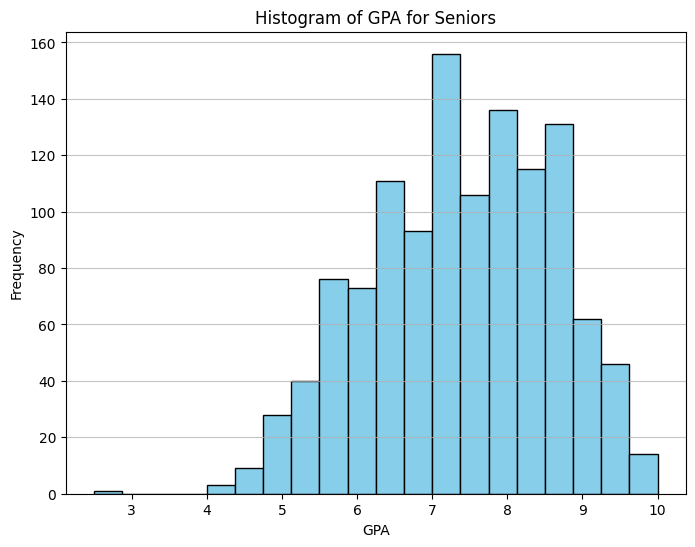

In [10]:
# Plot histogram of GPA data
plt.figure(figsize=(8, 6))
plt.hist(gpa_seniors_data, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of GPA for Seniors')
plt.xlabel('GPA')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

C:\Users\ethan\AppData\Local\Temp\ipykernel_24456\2786856023.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Node Weights')


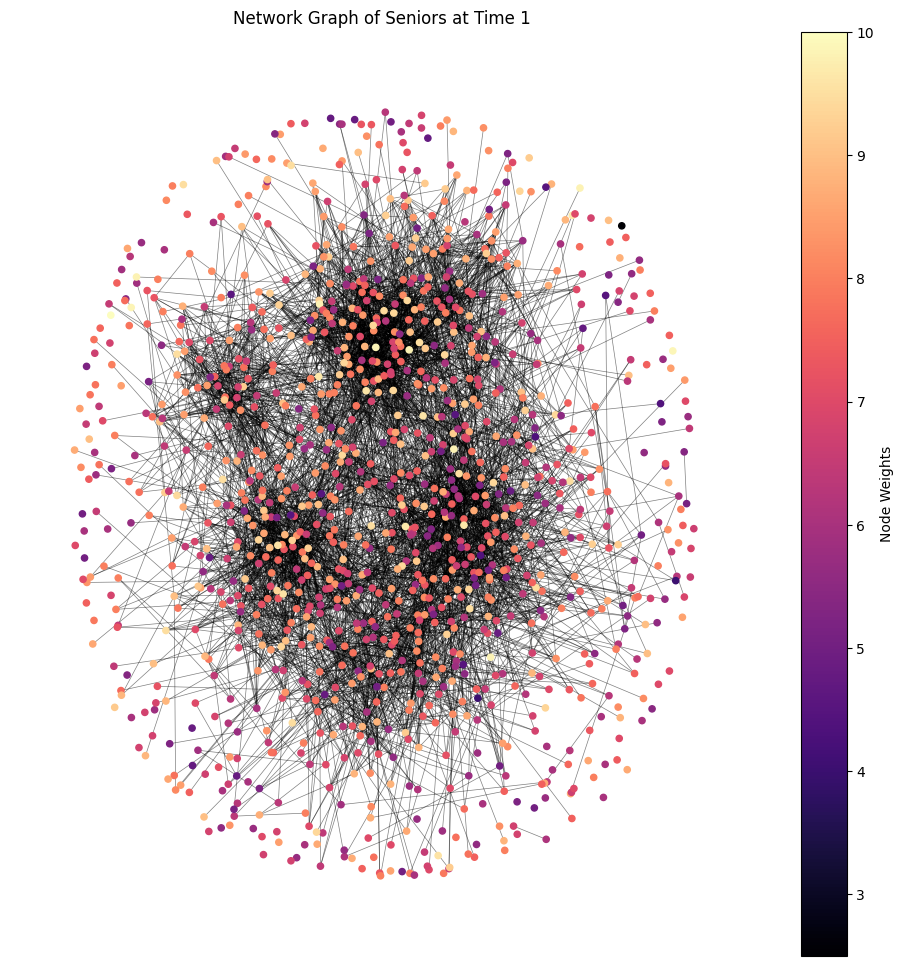

In [11]:
plot_network_from_matrix(networks_seniors_np['Sheet1'], plot_only_connected_nodes=False, title='Network Graph of Seniors at Time 1', node_weights=gpa_seniors_data.to_numpy())

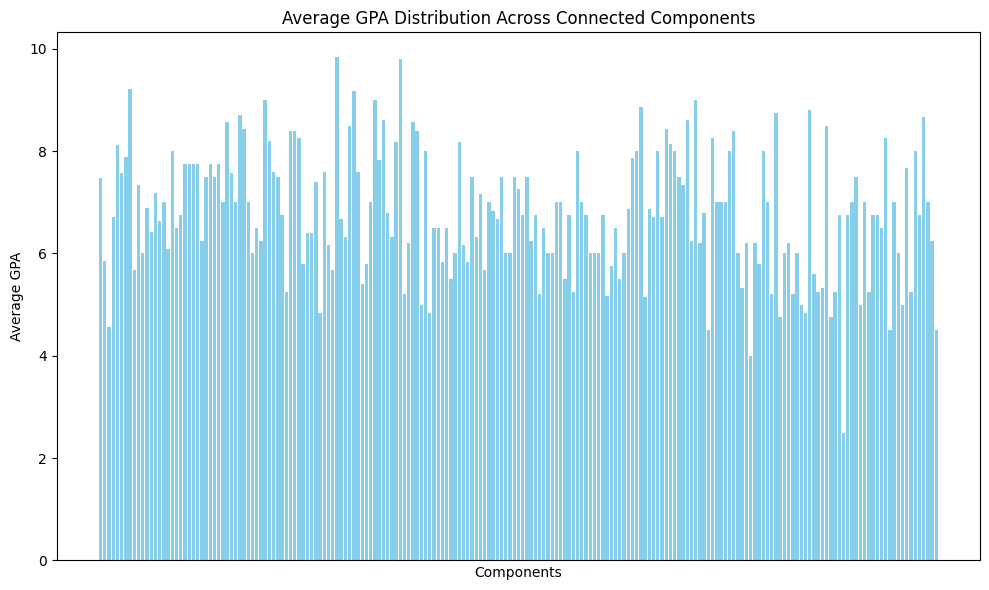

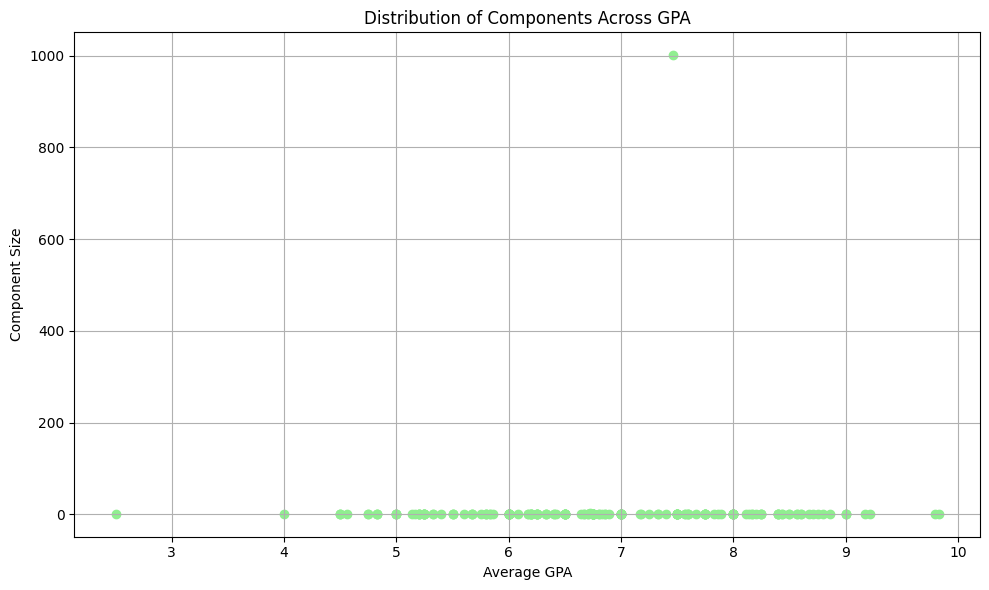

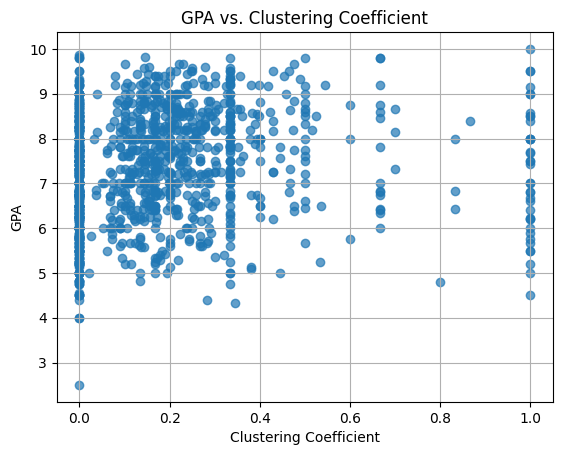

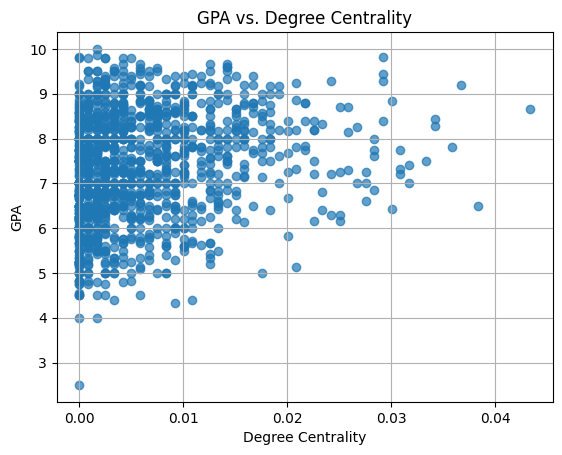

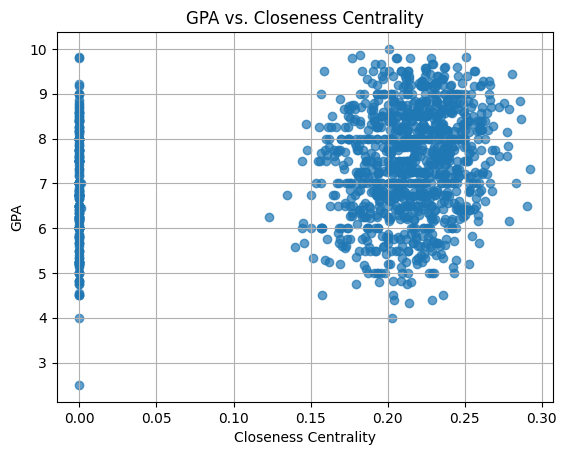

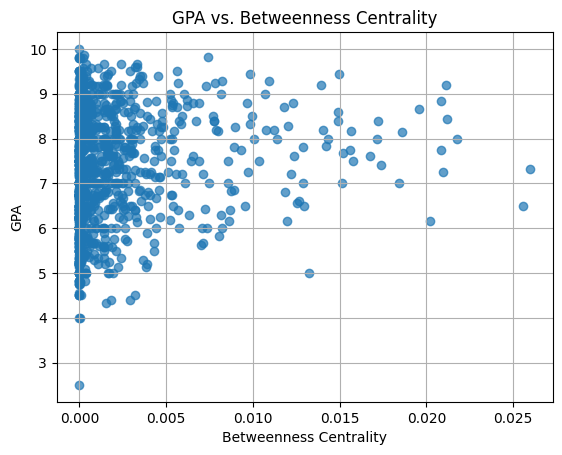

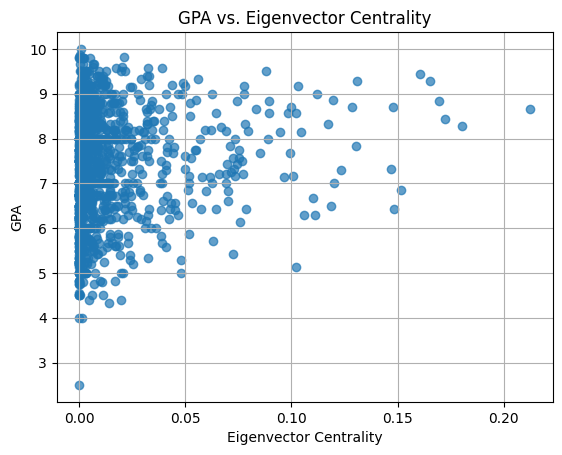

In [12]:
networks_seniors_report = network_analysis_with_gpa(networks_seniors_np['Sheet14'], gpa_seniors_data[0].to_numpy())

In [16]:
# Create a graph from the adjacency matrix in 'Sheet1'
G = nx.from_numpy_array(networks_seniors_np['Sheet1'])

# Use the Girvan-Newman algorithm to detect communities within the unipartite graph
communities = list(nx_comm.girvan_newman(G))

TypeError: 'list' object is not an iterator

1023


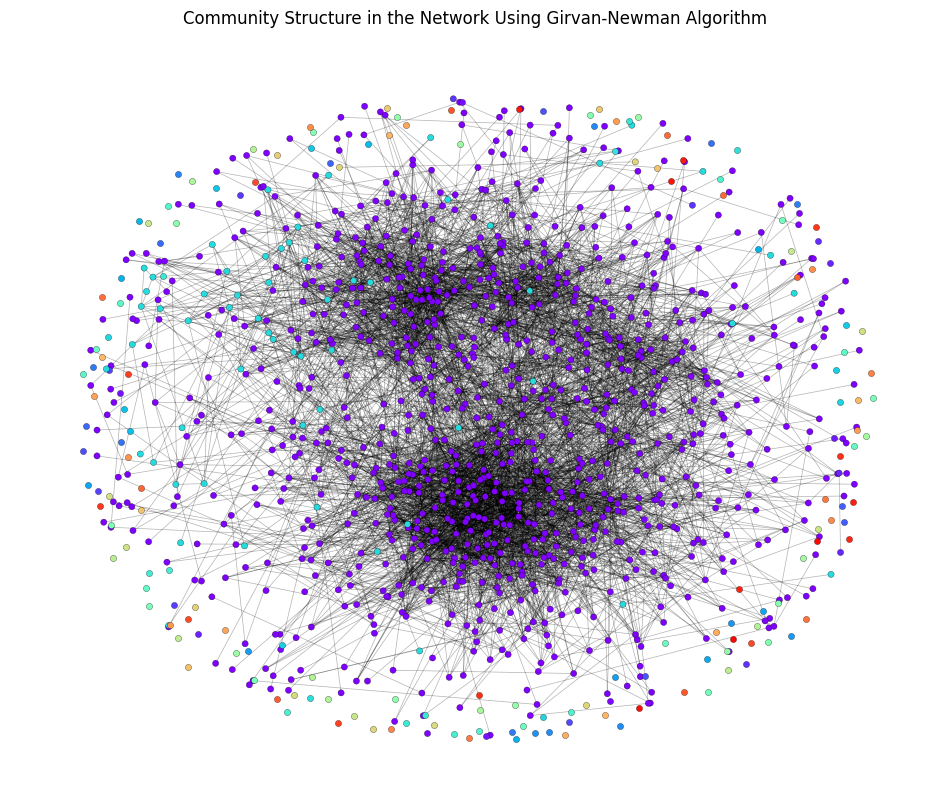

In [29]:
# To find smaller communities, iterate through the divisions until a desired level of division is reached
# This example iterates to the second level of division for more granular communities

print(len(communities))

for _ in range(1023):
    try:
        next_level_communities = next(iter(communities))
    except StopIteration:
        break
else:
    top_level_communities = next_level_communities

# Draw the graph with nodes colored by their community using a colormap
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.3)  # positions for all nodes

# Assigning unique colors for each community using a colormap
for i, community in enumerate(top_level_communities):
    color = plt.cm.rainbow(i / len(top_level_communities))
    nx.draw_networkx_nodes(G, pos, nodelist=list(community), node_color=[color for _ in range(len(community))], node_size=20, edgecolors='black', linewidths=0.2)
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)

plt.title('Community Structure in the Network Using Girvan-Newman Algorithm')
plt.axis('off')
plt.show()

In [15]:
# Perform HITS algorithm to compute hubs and authorities scores
hubs, authorities = nx.hits(G)

# Sort nodes based on hubs score in descending order
sorted_hubs = sorted(hubs.items(), key=lambda x: x[1], reverse=True)

# Sort nodes based on authorities score in descending order
sorted_authorities = sorted(authorities.items(), key=lambda x: x[1], reverse=True)

# Display top 5 hubs
print("Top 5 Hubs:")
for i, (node, score) in enumerate(sorted_hubs[:5]):
    print(f"{i+1}: Node {node} with hub score {score:.4f}")

# Display top 5 authorities
print("\nTop 5 Authorities:")
for i, (node, score) in enumerate(sorted_authorities[:5]):
    print(f"{i+1}: Node {node} with authority score {score:.4f}")

Top 5 Hubs:
1: Node 372 with hub score 0.0175
2: Node 438 with hub score 0.0169
3: Node 404 with hub score 0.0169
4: Node 440 with hub score 0.0147
5: Node 414 with hub score 0.0140

Top 5 Authorities:
1: Node 372 with authority score 0.0175
2: Node 438 with authority score 0.0169
3: Node 404 with authority score 0.0169
4: Node 440 with authority score 0.0147
5: Node 414 with authority score 0.0140
